In [1]:
from tensorflow.keras.applications import ResNet50V2, EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input
from data.datasets.image_classification import cats_dogs
import tensorflow as tf

image_size = (128, 128, 3)
inputs = Input(image_size)

dnet = DenseNet121(input_tensor=inputs, include_top=False, weights=None, pooling=None)

2023-04-07 20:10:45.863814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/fagg/miniconda3/envs/tf_bleeding5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow.keras.layers import Lambda
import tensorflow as tf
import numpy as np
class ConvMask(tf.keras.layers.Layer):
    """
    Interpretable CNN masking layer that turns the previous convolutional layer into an interpretable convolution
    https://arxiv.org/pdf/1710.00935.pdf
    
    At graph construction time this layer has two outputs one is the layer loss, the other is the forward pass output
    """

    def __init__(self, alpha=None, beta=4, tau=None):
        super(ConvMask, self).__init__()
        # layer hyperparameters
        self.tau = tau
        self.beta = beta
        self.alpha = alpha
        # set during build
        self.w = None
        self.h = None
        self.ch = None
        self.T = None
        self.p_of_T = None

    def build(self, input_shape):
        # pre-compute the forward pass masks, going to make them untrainable variables
        # need some way of converting the index to the masks
        # input shape = (none, h, w, ch)
        # only need the two inner dims to compute the number of masks there are h * w + 1 of them
        batch, h, w, ch = input_shape
        self.w = w
        self.h = h
        self.ch = ch
        # parameter values from the paper
        self.tau = self.tau if self.tau is not None else .5 / (w*h)
        self.alpha = self.alpha if self.alpha is not None else w*h / (1 + w*h)
        self.beta = self.beta if self.beta is not None else 4
        
        T = []
        for i in range(h*w):
            t_i = np.ones((h, w), dtype=np.float32)
            for j in range(h):
                for k in range(w):
                    # if we index this way then it's j*h + k to get the correct map for T[j, k]
                    t_i[j][k] -= self.beta * ((abs((i // h) - j) + abs(i % w - k)) / w)
            T.append(self.tau * tf.maximum(t_i, -1))
        
        t_minus = -self.tau*tf.ones((h, w))
        
        T = [t_minus] + T
        # stack each mask
        self.T = tf.Variable(tf.stack(T, 0), trainable=False)
        # stack the prior probabilities of each mask
        self.p_of_T = tf.stack([1 - self.alpha] + [self.alpha / (w*h) for i in range(w*h)])

    def call(self, inputs, training=None):
        # going to do something a little hacky with the call where the layer is going to directly report the loss which will go directly to loss fn
        # reshape the inputs to compute the correct mask for each filter
        inputs_reshaped = tf.keras.layers.Reshape((self.w*self.h, self.ch))(inputs)
        # simply apply the mask to each filter
        output = Lambda(lambda x: tf.maximum(inputs * tf.transpose(tf.gather(self.T, tf.argmax(x, 1) + 1, axis=0, batch_dims=0), perm=(0, 2, 3, 1)), 0))(inputs_reshaped)
        # the rest of the computation is the layer loss, which is the mutual information between the filters and the instances of the dataset
        # we will estimate it over the batch
        # nan possible, requires batch dimension
        bcast_p_of_T = tf.broadcast_to(tf.expand_dims(self.p_of_T, axis=-1), (self.p_of_T.shape[0], self.ch))
        p_of_x_given_T = tf.reduce_sum(tf.map_fn(lambda x: tf.stack([tf.expand_dims(self.T[0], -1) * x] + [tf.cast(tf.expand_dims(self.T[i + 1], -1) * x, tf.float32) for i in range(self.w*self.h)]), inputs), axis=(2, 3))
        # softmax along batch axis
        p_of_x_given_T = tf.nn.softmax(p_of_x_given_T, axis=0)

        p_x = tf.reduce_sum(p_of_x_given_T * bcast_p_of_T, axis=1, keepdims=True)

        loss = tf.reduce_sum(tf.reduce_sum(bcast_p_of_T, axis=0) * tf.reduce_sum(p_of_x_given_T, axis=0) * tf.reduce_sum(tf.math.log(p_of_x_given_T / p_x), axis=0), axis=(0, 1))
        # loss is defined over the batch, so just repeat the loss for each element for tensorflow to have the correct expected output shape
        loss = tf.broadcast_to(tf.expand_dims(tf.math.negative(loss), 0), tf.shape(tf.reduce_sum(inputs, axis=(1, 2, 3))))
        
        return output, loss

    def get_config(self):
        return {"T": self.T.numpy(), "alpha": self.alpha, "beta": self.beta, "tau": self.tau, "w": self.w, "h": self.h, "ch": self.ch}


In [3]:
from tensorflow.keras.applications import DenseNet121
from data.datasets.image_classification import cats_dogs

def CE(y_true, y_pred):
    """
    cross-entropy
    """
    return tf.math.negative(tf.reduce_sum(tf.math.log(y_pred) * y_true, axis=-1))

def identity(y_true, y_pred):
    """
    the identity transformation
    """
    return y_pred


image_size = (128, 128, 3)

def ICNN_DenseNet121(image_size, n_classes):
    inputs = Input(image_size)
    dnet = DenseNet121(input_tensor=inputs, include_top=False, weights=None, pooling=None)
    inp = tf.keras.layers.Input(image_size)
    x = dnet(inp)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x, loss = ConvMask()(x)
    x = tf.keras.layers.Conv2D(x.shape[-1], kernel_size=3, activation='relu', padding='same')(x)
    x, loss1 = ConvMask()(x)
    x = tf.keras.layers.Flatten()(x)
    outp = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    outputs = {'crossentropy': outp, 'loss_f': loss + loss1}

    model = tf.keras.models.Model(inputs=inp, outputs=outputs)

    opt = tf.keras.optimizers.Nadam(learning_rate=1e-4,
                                    beta_1=0.9, beta_2=0.999,
                                    epsilon=None, decay=0.99)

    opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

    model.compile(loss={'crossentropy': CE, 'loss_f': identity},
                      loss_weights=[1, 5e-6],
                      optimizer=opt,
                      metrics={'crossentropy': ['categorical_accuracy'], 'loss_f': []}
                      )

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet121 (Functional)       (None, 4, 4, 1024)   7037504     ['input_3[0][0]']                
                                                                                                  
 activation (Activation)        (None, 4, 4, 1024)   0           ['densenet121[0][0]']            
                                                                                                  
 conv_mask (ConvMask)           ((None, 4, 4, 1024)  272         ['activation[0][0]']         

In [4]:
dset_dict = cats_dogs(image_size=(128, 128))

Corrupt JPEG data: 104 extraneous bytes before marker 0xd9
Corrupt JPEG data: 402 extraneous bytes before marker 0xd9
Corrupt JPEG data: 70 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2232 extraneous bytes before marker 0xd9
Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1158 extraneous bytes before marker 0xd9
Corrupt JPEG data: 232 extraneous bytes before marker 0xd9


tf.Tensor([[8195. 8088.]], shape=(1, 2), dtype=float32) tf.Tensor([[0.50328565 0.49671435]], shape=(1, 2), dtype=float32) (16283, 2)


Corrupt JPEG data: 133 extraneous bytes before marker 0xd9


tf.Tensor([[1183. 1144.]], shape=(1, 2), dtype=float32) tf.Tensor([[0.5083799  0.49162012]], shape=(1, 2), dtype=float32) (2327, 2)


Corrupt JPEG data: 164 extraneous bytes before marker 0xd9
Corrupt JPEG data: 259 extraneous bytes before marker 0xd9
Corrupt JPEG data: 217 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1408 extraneous bytes before marker 0xd9


tf.Tensor([[2280. 2372.]], shape=(1, 2), dtype=float32) tf.Tensor([[0.49011177 0.50988823]], shape=(1, 2), dtype=float32) (4652, 2)


Corrupt JPEG data: 104 extraneous bytes before marker 0xd9
Corrupt JPEG data: 402 extraneous bytes before marker 0xd9
Corrupt JPEG data: 70 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2232 extraneous bytes before marker 0xd9
Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1158 extraneous bytes before marker 0xd9
Corrupt JPEG data: 232 extraneous bytes before marker 0xd9
Corrupt JPEG data: 104 extraneous bytes before marker 0xd9
Corrupt JPEG data: 402 extraneous bytes before marker 0xd9
Corrupt JPEG data: 70 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2232 extraneous bytes before marker 0xd9
Corrupt JPEG data: 242 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1158 extraneous bytes before marker 0xd9
Corrupt JPEG data: 232 extraneous bytes before marker 0xd9
Corrupt JPEG data: 133 extraneous bytes before marker 0xd9

In [5]:
train = dset_dict['train'].shuffle(256).batch(64)
val = dset_dict['val'].shuffle(256).batch(64)

history = model.fit(train, validation_data=val, epochs=10)

Epoch 1/10


2023-04-07 20:14:30.640630: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-07 20:14:30.844627: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


255/255 [==============================] - 146s 353ms/step - loss: 0.6608 - dense_loss: 0.6589 - tf.__operators__.add_loss: 393.0752 - dense_categorical_accuracy: 0.5902 - val_loss: 0.6980 - val_dense_loss: 0.6979 - val_tf.__operators__.add_loss: 9.9319 - val_dense_categorical_accuracy: 0.5140
Epoch 2/10
255/255 [==============================] - 82s 319ms/step - loss: 0.4506 - dense_loss: 0.4473 - tf.__operators__.add_loss: 661.4297 - dense_categorical_accuracy: 0.7914 - val_loss: 0.8011 - val_dense_loss: 0.7996 - val_tf.__operators__.add_loss: 305.3252 - val_dense_categorical_accuracy: 0.5776
Epoch 3/10
255/255 [==============================] - 82s 320ms/step - loss: 0.3395 - dense_loss: 0.3359 - tf.__operators__.add_loss: 711.8434 - dense_categorical_accuracy: 0.8488 - val_loss: 0.4296 - val_dense_loss: 0.4268 - val_tf.__operators__.add_loss: 546.0424 - val_dense_categorical_accuracy: 0.8126
Epoch 4/10
255/255 [==============================] - 82s 322ms/step - loss: 0.2635 - dense

In [ ]:
history = model.fit(train, validation_data=val, epochs=10)

In [6]:
def min_max_normalize_image(image):
    # image = 

    image -= tf.reduce_min(image)
    image /= tf.reduce_max(image)

    return image

(128, 128, 1024)


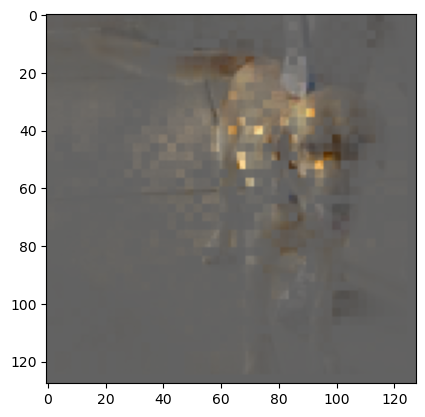

(128, 128, 1024)


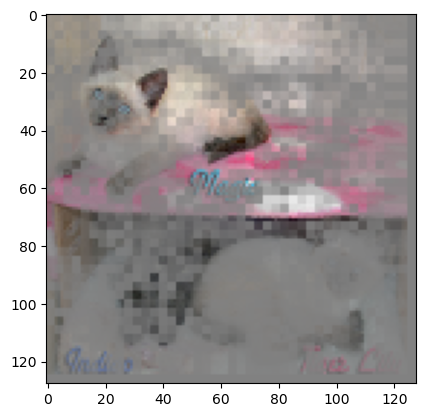

(128, 128, 1024)


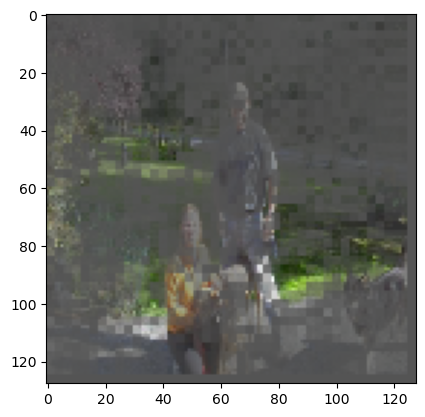

(128, 128, 1024)


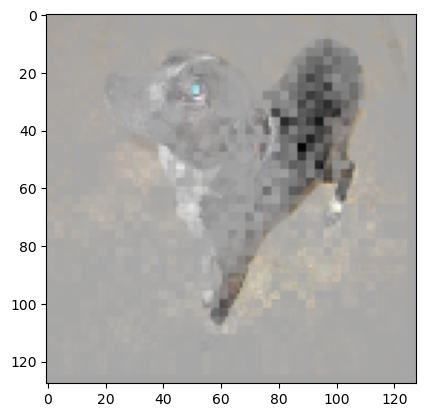

(128, 128, 1024)


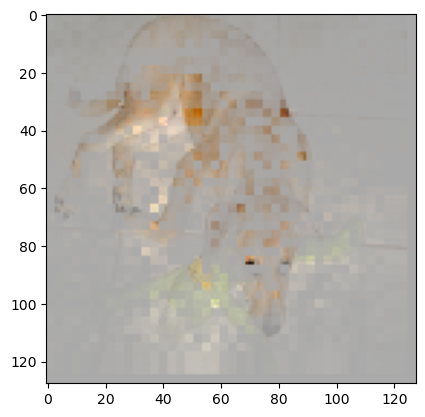

(128, 128, 1024)


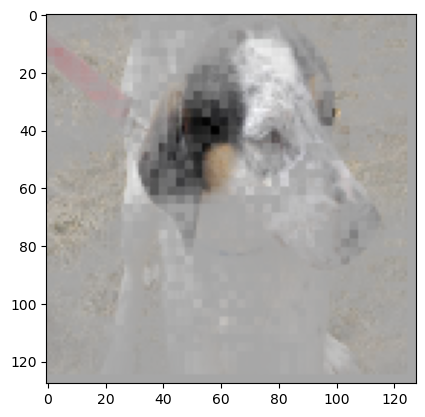

In [ ]:
def get_rf(model, instance, patch_size=8, stride=3, randrange=(-1, 1), layer=-4):
    new_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[layer].output[0])
    
    # Create function to apply a random patch on an image tiled across the whole image to get the receptive field of a  
    bottom, top = randrange
    def apply_random_patch(image, top_left_x, top_left_y, patch_size):
        patched_image = np.array(image, copy=True)
        patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = tf.random.uniform((patch_size, patch_size, image.shape[-1]), maxval=top, minval=bottom)

        return patched_image
    
    img = instance[0]
    
    sensitivity_map = np.zeros((img.shape[0], img.shape[1], new_model.output.shape[-1]), dtype=float)
    original_features = new_model(instance)

    # Iterate the patch over the image
    for top_left_x in range(0, img.shape[0] - patch_size, stride):
        for top_left_y in range(0, img.shape[1] - patch_size, stride):
            patched_image = apply_random_patch(img, top_left_x, top_left_y, patch_size)
            predicted_classes = new_model.predict(np.array([patched_image]), verbose=0)
            # Save difference for this specific patched image in map
            sensitivity_map[
                top_left_y:top_left_y + patch_size,
                top_left_x:top_left_x + patch_size,
            ] = tf.reduce_sum(tf.abs(tf.subtract(original_features, predicted_classes)), axis=(1, 2))  # L1 difference
            
    return sensitivity_map

for x, y in dset_dict['test'].batch(1):
    img = x[0]
    rf = get_rf(model, x)
    print(rf.shape)
    
    plt.imshow(min_max_normalize_image(tf.cast(tf.reduce_sum(tf.nn.relu(rf), axis=-1, keepdims=True), tf.float32) * tf.cast(img, tf.float32)))
    plt.show()
    plt.clf()
    input()

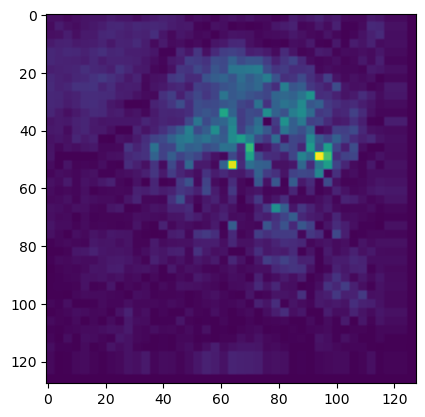

In [15]:
import matplotlib.pyplot as plt

plt.imshow(min_max_normalize_image(tf.reduce_sum(tf.nn.relu(rf), axis=-1)), 'viridis')
plt.show()

In [93]:
(tf.cast(min_max_normalize_image(tf.reduce_sum(rf, axis=-1, keepdims=True)), tf.float32) * tf.cast(img, tf.float32)).shape

TensorShape([128, 128, 3])

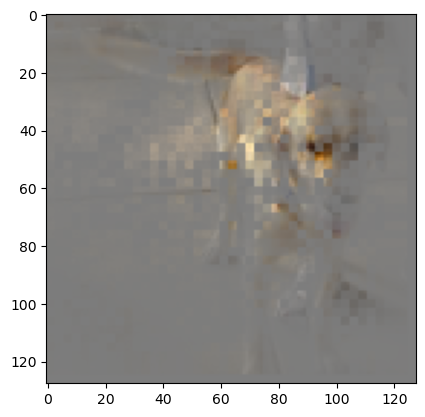

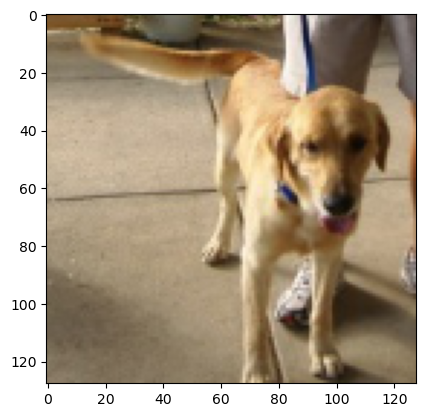

In [17]:
plt.imshow(min_max_normalize_image(tf.cast(min_max_normalize_image(img), tf.float32)))
plt.show()

In [70]:
b, h, w, ch = 12, 8, 8, 16
beta = .999
alpha = .9
T = [-1*tf.ones((h, w))]
for i in range(h*w):
    t_i = np.ones((h, w))
    for j in range(h):
        for k in range(w):
            # if we index this way then it's i*h + j to get the correct map for T[i, j]
            t_i[j][k] -= beta * ((abs((i // h) - j) + abs(i % w - k)) / w)
    T.append(t_i)
    assert tf.argmax(tf.reshape(t_i, (h*w, ))) == i
    print(i, end='\r')

In [100]:
tf.expand_dims(T[i + 1], -1).shape
tf.random.uniform((h, w, ch), minval=0, maxval=1, dtype=tf.float64).shape

TensorShape([8, 8, 16])

In [114]:
p_of_T = tf.stack([1 - alpha] + [alpha / (w*h) for i in range(w*h)])
bcast_p_of_T = tf.broadcast_to(tf.expand_dims(tf.expand_dims(tf.expand_dims(p_of_T, axis=-1), axis=-1), axis=-1), (p_of_T.shape[0], w, h, ch))
print(bcast_p_of_T.shape)
# input feature maps
inputs = tf.random.uniform((h, w, ch), minval=0, maxval=1, dtype=tf.double)

from tensorflow.keras.layers import Lambda
# forward pass predict
masks = Lambda(lambda x: tf.gather(T, tf.argmax(tf.reshape(x, (h*w, ch))) + 1, axis=0, batch_dims=0))(inputs)
# shape is (batch, w*h, w, h, ch)
masks = Lambda(lambda masks: tf.transpose(masks, perm=(1, 2, 0)))(masks)
#masks = tf.gather(T, tf.argmax(tf.reshape(inputs[0], (h*w, ch))) + 1, axis=0, batch_dims=0)

p_of_x_given_T = Lambda(lambda x: tf.stack([tf.expand_dims(T[0], -1) * x] + [tf.cast(tf.expand_dims(T[i + 1], -1) * tf.cast(x, tf.double), tf.float32) for i in range(w*h)]))(inputs)
# softmax along batch axis
p_of_x_given_T = tf.nn.softmax(p_of_x_given_T, axis=0)

p_x = tf.reduce_sum(p_of_x_given_T * bcast_p_of_T, axis=1, keep_dims=True)

loss = tf.reduce_sum(tf.reduce_sum(bcast_p_of_T, axis=1) * tf.reduce_sum(p_of_x_given_T, axis=1) * tf.reduce_sum(tf.math.log(p_of_x_given_T / p_x), axis=1), axis=0)

loss = tf.math.negative(loss)

print(p_of_x_given_T.shape)

print(tf.reduce_sum(tf.cast(masks, tf.double) * inputs, axis=(1, 2)).shape)
p_of_x_given_T = Lambda(lambda x: tf.nn.softmax(tf.reduce_sum(x[0] * x[1], axis=(0, 1)), axis=0))((masks, inputs))
print(p_of_T.shape, p_of_x_given_T.shape)
p_of_x = tf.reduce_sum(p_of_T * p_of_x_given_T, axis=-1)

(65, 8, 8, 16)
(65, 8, 8, 16)
(8,)
(65,) (16,)


2023-04-06 17:25:23.092687: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Mul]

In [4]:
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                       

In [1]:
from data.datasets.image_classification import cats_dogs
import tensorflow_datasets as tfds
import pickle
'''
dset_dict = cats_dogs(image_size=(128, 128))

dset_dict = {k: tfds.as_numpy(dset_dict[k]) for k in dset_dict if k != 'class_names'}

dset_dict = {k: (np.stack([x for x, y in dset_dict[k]]),
                 np.stack([y for x, y in dset_dict[k]]))
             for k in dset_dict}

with open('./data/cats_dogs_numpy_128_128.pkl', 'wb') as fp:
    pickle.dump(dset_dict, fp)
    '''

2023-04-05 19:38:42.324742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 19:38:42.408983: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/fagg/miniconda3/envs/tf_bleeding5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"\ndset_dict = cats_dogs(image_size=(128, 128))\n\ndset_dict = {k: tfds.as_numpy(dset_dict[k]) for k in dset_dict if k != 'class_names'}\n\ndset_dict = {k: (np.stack([x for x, y in dset_dict[k]]),\n                 np.stack([y for x, y in dset_dict[k]]))\n             for k in dset_dict}\n\nwith open('./data/cats_dogs_numpy_128_128.pkl', 'wb') as fp:\n    pickle.dump(dset_dict, fp)\n    "

In [2]:
import pickle
import numpy as np

with open('./data/cats_dogs_numpy_128_128.pkl', 'rb') as fp:
    dsets = pickle.load(fp)
    
dsets = {k: (np.transpose(dsets[k][0], axes=(0, 3, 1, 2)), 
             np.expand_dims(dsets[k][1], axis=(2, 3)))  # really hate this, should be able to change
         for k in dsets}

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
print([(dsets[k][0].shape, dsets[k][1].shape) for k in dsets])

[((16283, 3, 128, 128), (16283, 2, 1, 1)), ((2327, 3, 128, 128), (2327, 2, 1, 1)), ((4652, 3, 128, 128), (4652, 2, 1, 1))]


In [ ]:
import h5py
import math
import copy
import scipy.io as io
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.nn.parameter import Parameter
import torch.autograd.variable as Variable


class Divclass:
    def __init__(self, depthList, posList):
        self.depthList = depthList
        self.posList = posList


def getMu(x):
    IsuseMax = 0
    bs = x.size()[0]
    depth = x.size()[1]
    h = x.size()[2]
    w = x.size()[3]
    x = x.transpose(2, 3).reshape([bs, depth, h * w])
    if (IsuseMax):
        _, p = torch.max(x, dim=2)
        p = torch.reshape(p, (bs, depth, 1)).float()  # index is long type
        mu_y = torch.ceil(p / h)
        mu_x = p - (mu_y - 1) * h
        sqrtvar = torch.Tensor([])
    else:
        tmp_x = torch.Tensor(range(1, h + 1)).reshape(-1, 1).repeat([bs, depth, w, 1]).squeeze(3).cuda()
        tmp_y = torch.Tensor(range(1, w + 1)).repeat([bs, depth, h, 1])
        tmp_y = tmp_y.transpose(2, 3).reshape([bs, depth, h * w]).cuda()
        sumXtmp = torch.sum(x, 2).unsqueeze(2)
        sumX = torch.max(sumXtmp, (torch.ones(sumXtmp.size()).cuda() * 0.000000001))
        mu_xtmp = torch.round((torch.sum(tmp_x.mul(x), 2).unsqueeze(2)).div(sumX))
        mu_x = torch.max(mu_xtmp, torch.ones(mu_xtmp.size()).cuda())
        mu_ytmp = torch.round((torch.sum(tmp_y.mul(x), 2).unsqueeze(2)).div(sumX))
        mu_y = torch.max(mu_ytmp, torch.ones(mu_ytmp.size()).cuda())
        sqrtvartmp1 = mu_x.repeat([1, 1, h * w])
        sqrtvartmp2 = mu_y.repeat([1, 1, h * w])
        sqrtvar = torch.sqrt((torch.sum((tmp_x - sqrtvartmp1).mul(tmp_x - sqrtvartmp1).mul(x), 2).unsqueeze(2) + torch.sum((tmp_y - sqrtvartmp2).mul(tmp_y - sqrtvartmp2).mul(x), 2).unsqueeze(2)).div(sumX))
        p = (mu_x + (mu_y - 1) * h).reshape([bs, depth, 1, 1])
    tmp = torch.linspace(-1, 1, h).repeat(mu_x.size()).cuda()
    for i in range(bs):
        mu_x[i, :, :] = torch.gather(tmp[i, :, :], 1, (mu_x[i, :, :] - 1).long())
        mu_y[i, :, :] = torch.gather(tmp[i, :, :], 1, (mu_y[i, :, :] - 1).long())
    mu_x = mu_x.reshape([bs, depth, 1, 1])
    mu_y = mu_y.reshape([bs, depth, 1, 1])
    sqrtvar = sqrtvar.reshape([bs, depth])
    return mu_x, mu_y, sqrtvar


def getMask(mask_parameter, mask_weight, posTempX, posTempY, bs, depth, h, w):
    mask = torch.abs(posTempX - mask_parameter['mu_x'].repeat([1, 1, h, w]))
    mask = mask + torch.abs(posTempY - mask_parameter['mu_y'].repeat([1, 1, h, w]))
    mask = 1 - mask.mul(mask_weight.reshape(depth, 1, 1).repeat([bs, 1, h, w]))
    mask = torch.max(mask, torch.ones(mask.size()).cuda() * (-1))
    for i in range(depth):
        if not (mask_parameter['filter'][i].equal(torch.ones(1))):
            mask[:, i, :, :] = 1
    return mask


def get_sliceMag(sliceMag, label, x):
    # for each label class
    for lab in range(label.shape[1]):
        # get the indicies of labels for that class
        index = (label[:, lab, :, :] == 1).squeeze()
        # if that class is in the batch, then update sliceMag
        if torch.sum(index):
            # get the max spatial value for each filter of the layer (size is now [batch, ch, 1, 1])
            tmp = torch.amax(x.cpu()[index.cpu()], dim=(2, 3), keepdim=False).cuda()
            # get the batch mean
            meantmp = torch.mean(tmp, 0)
            # if the sum of sliceMag is not zero, set the minimum value of each to 0.1
            if torch.sum(sliceMag[:, lab]) != 0:
                sliceMag[:, lab] = torch.max(meantmp, (torch.ones(meantmp.size()) * 0.1).cuda())
            # otherwise, take a weighted average
            else:
                index = (meantmp == 0).squeeze()
                meantmp.cpu()[torch.ones(meantmp.size()).bool()] = sliceMag[index.cpu(), 0] # .cuda()
                sliceMag[:, lab] = (sliceMag[:,lab] * 0.9).cuda() + meantmp*0.1
    return sliceMag


class conv_mask_F(Function):
    @staticmethod
    def forward(self, x, weight, bias, mask_weight, padding, label, Iter, density, mask_parameter):
        bs = x.shape[0]
        depth = x.shape[1]
        h = x.shape[2]
        w = x.shape[3]
        posTemp_x = torch.linspace(-1, 1, h).reshape(-1, 1).repeat([depth, 1, w])
        posTemp_y = torch.linspace(-1, 1, w).repeat([depth, h, 1])
        posTempX = posTemp_x.repeat([bs, 1, 1, 1]).cuda()
        posTempY = posTemp_y.repeat([bs, 1, 1, 1]).cuda()
        mask_parameter['mu_x'], mask_parameter['mu_y'], mask_parameter['sqrtvar'] = getMu(x)
        mask = getMask(mask_parameter, mask_weight, posTempX, posTempY, bs, depth, h, w)
        input = x.mul(mask)
        x_relu = torch.max(input, torch.zeros(input.size()).cuda())

        parameter_sliceMag = mask_parameter['sliceMag'].clone().data
        mask_parameter['sliceMag'] = get_sliceMag(mask_parameter['sliceMag'],label,x)

        self.save_for_backward(x, weight, bias, mask_weight, torch.Tensor([padding]), label, mask, Iter, density,
                               mask_parameter['filter'], mask_parameter['mag'], mask_parameter['sqrtvar'], mask_parameter['strength'],parameter_sliceMag)

        return F.conv2d(x_relu, weight, bias, padding=padding)

    @staticmethod
    def backward(self, grad_output):
        x, weight, bias, mask_weight, padding, label, mask, Iter, density, parameter_filter, parameter_mag, parameter_sqrtvar, parameter_strength, parameter_sliceMag = self.saved_tensors

        input = x.mul(torch.max(mask, torch.zeros(mask.size()).cuda()))
        if self.needs_input_grad[0]:
            x_grad = torch.nn.grad.conv2d_input(input.shape, weight, grad_output, padding=int(padding.item()))
        if self.needs_input_grad[1]:
            weight_grad = torch.nn.grad.conv2d_weight(input, weight.shape, grad_output, padding=int(padding.item()))
        if bias is not None and self.needs_input_grad[2]:
            bias_grad = grad_output.sum(0).sum((1, 2))

        depth = x.size()[1]
        h = x.size()[2]
        w = x.size()[3]
        depthList = (parameter_filter > 0).nonzero()[:, 0].reshape(-1, 1)
        labelNum = label.size()[1]
        Div_list = []

        if (labelNum == 1):
            theClass = label
            posList = (theClass == 1).nonzero()[:, 0].reshape(-1, 1)
            Div = Divclass(depthList, posList)
            Div_list.append(Div)
        else:
            (theClass, indextmp) = torch.max(label, dim=1)
            theClass = theClass.unsqueeze(2)
            if (parameter_sliceMag.size()[0] == torch.Tensor([]).size()[0]):
                posList = (theClass == 1).nonzero()[:, 0].reshape(-1, 1)
                Div = Divclass(depthList, posList)
                Div_list.append(Div)
            else:
                sliceM = parameter_sliceMag
                for i in range(labelNum):
                    Div = Divclass(depthList=torch.Tensor([]), posList=torch.Tensor([]))
                    Div_list.append(Div)
                (val, index) = torch.max(sliceM[depthList, :].squeeze(1), dim=1)
                for lab in range(labelNum):
                    (Div_list[lab].depthList, indextmp) = torch.sort(depthList[index == lab], dim=0)
                    Div_list[lab].posList = (label[:, lab, :, :] == 1).nonzero()[:, 0].reshape(-1, 1)

        imgNum = label.size()[0]
        alpha = 0.5
        x_grad = x_grad.mul(torch.max(mask, torch.zeros(mask.size()).cuda()))

        if ((torch.sum(parameter_filter == 1)) > 0):
            parameter_strength = torch.mean(torch.mean(x.mul(mask), 2), 2).transpose(1, 0).cuda()
            mask_tmp = (torch.from_numpy(copy.deepcopy(mask.cpu().detach().numpy()[::-1, ::-1, :, :]))).cuda()
            alpha_logZ_pos = (torch.log(torch.mean(torch.exp(torch.mean(torch.mean(x.mul(mask_tmp), 2), 2).div(alpha)), 0)) * alpha).reshape(depth, 1)
            alpha_logZ_neg = (torch.log(torch.mean(torch.exp(torch.mean(torch.mean(-x, 2), 2).div(alpha)), 0)) * alpha).reshape(depth, 1)

            alpha_logZ_pos[torch.isinf(alpha_logZ_pos)] = torch.max(alpha_logZ_pos[torch.isinf(alpha_logZ_pos) == 0])
            alpha_logZ_neg[torch.isinf(alpha_logZ_neg)] = torch.max(alpha_logZ_neg[torch.isinf(alpha_logZ_neg) == 0])

        for lab in range(len(Div_list)):
            if (labelNum == 1):
                w_pos = 1
                w_neg = 1
            else:
                if (labelNum > 10):
                    w_pos = 0.5 / (1 / labelNum)
                    w_neg = 0.5 / (1 - 1 / labelNum)
                else:
                    w_pos = 0.5 / density[lab]
                    w_neg = 0.5 / (1 - density[lab])

            mag = torch.ones([depth, imgNum]).div(1 / Iter).div(parameter_mag).cuda()
            dList = Div_list[lab].depthList
            dList = dList[(parameter_filter[dList] == 1).squeeze(1)].reshape(-1, 1)
            if (dList.size()[0] != torch.Tensor([]).size()[0]):
                List = Div_list[lab].posList.cuda()
                if (List.size()[0] != torch.Tensor([]).size()[0]):
                    strength = torch.exp((parameter_strength[:, List].squeeze(2))[dList, :].squeeze(1).div(alpha)).mul((parameter_strength[:, List].squeeze(2))[dList, :].squeeze(1) - alpha_logZ_pos[dList].squeeze(1).repeat(1, List.size()[0]) + alpha)
                    # restrict
                    strength[torch.isinf(strength)] = torch.max(strength[torch.isinf(strength) == 0])
                    strength[torch.isnan(strength)] = 0
                    strength = (strength.div((torch.mean(strength, 1).reshape(-1, 1).repeat(1, List.size()[0])).mul((mag[:, List].squeeze(2))[dList, :].squeeze(1)))).transpose(0, 1).reshape(List.size()[0],dList.size()[0], 1, 1)
                    strength[torch.isnan(strength)] = 0
                    # restrict
                    strength[torch.isinf(strength)] = torch.max(strength[torch.isinf(strength) == 0])
                    index_dList = dList.repeat(List.size()[0], 1)
                    index_List = List.reshape(-1, 1).repeat(1, dList.size()[0]).reshape(List.size()[0] * dList.size()[0], 1)
                    x_grad[index_List, index_dList, :, :] = ((x_grad[List, :, :, :].squeeze(1))[:, dList, :, :].squeeze(2) - (mask[List, :, :,:].squeeze(1))[:,dList,:,:].squeeze(2).mul(strength.repeat(1, 1, h, w) * (0.00001 * w_pos))).reshape(List.size()[0] * dList.size()[0],1, h, w)

                list_neg = (label != 1).nonzero()[:, 0].reshape(-1, 1)
                if (list_neg.size()[0] != torch.Tensor([]).size()[0]):
                    strength = torch.mean((torch.mean((x[list_neg, :, :, :].squeeze(1))[:, dList, :, :].squeeze(2), 2).unsqueeze(2)),3).unsqueeze(2).transpose(0, 1).reshape(dList.size()[0], list_neg.size()[0])
                    strength = torch.exp(-strength.div(alpha)).mul(-strength - alpha_logZ_neg[dList].squeeze(2).repeat(1, list_neg.size()[0]) + alpha)
                    # restrict
                    strength[torch.isinf(strength)] = torch.max(strength[torch.isinf(strength) == 0])
                    #strength[torch.isinf(strength)] = torch.max(strength[torch.isinf(strength) == 0])
                    strength[torch.isnan(strength)] = 0
                    strength = (strength.div((torch.mean(strength, 1).reshape(-1, 1).repeat(1, list_neg.size()[0])).mul((mag[:, list_neg].squeeze(2))[dList, :].squeeze(1)))).transpose(0, 1).reshape(list_neg.size()[0], dList.size()[0], 1, 1)
                    strength[torch.isnan(strength)] = 0
                    # restrict
                    strength[torch.isinf(strength)] = torch.max(strength[torch.isinf(strength) == 0])
                    index_dList = dList.repeat(list_neg.size()[0], 1)
                    index_list_neg = list_neg.reshape(-1, 1).repeat(1, dList.size()[0]).reshape(list_neg.size()[0] * dList.size()[0], 1)
                    x_grad[index_list_neg, index_dList, :, :] = ((x_grad[list_neg, :, :, :].squeeze(1))[:, dList, :, :].squeeze(2) + (strength.reshape(list_neg.size()[0], dList.size()[0], 1, 1).repeat(1, 1, h, w)) * (0.00001 * w_neg)).reshape(list_neg.size()[0] * dList.size()[0], 1, h, w)

        beta = 3.0
        mask_weight_grad = torch.zeros(depth, 1).cuda()
        parameter_sqrtvar = parameter_sqrtvar.transpose(0, 1)

        for lab in range(len(Div_list)):
            dList = Div_list[lab].depthList.cuda()
            List = Div_list[lab].posList
            if ((dList.size()[0] != torch.Tensor([]).size()[0]) and (List.size()[0] != torch.Tensor([]).size()[0])):
                tmp = ((torch.sum((parameter_strength[:, List].squeeze(2))[dList, :].squeeze(1).mul((parameter_sqrtvar[:, List].squeeze(2))[dList, :].squeeze(1)), 1)).
                       div(torch.sum((parameter_strength[:, List].squeeze(2))[dList, :].squeeze(1), 1))).reshape(-1, 1)
                tmptmp = beta / tmp
                tmp = torch.max(torch.min(tmptmp, torch.ones(tmptmp.size()).cuda() * 3),torch.ones(tmptmp.size()).cuda() * 1.5)
                tmp = (tmp - mask_weight[dList].squeeze(2)) * (-10000)
                mask_weight_grad[dList] = tmp.unsqueeze(2)

        return x_grad, weight_grad, bias_grad, mask_weight_grad, None, None, None, None, None, None, None, None, None, None, None


class conv_mask(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, labelnum, loss_type, ):
        super(conv_mask, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding[0]
        self.alphainit = 2.0
        self.mask_parameter = None
        self.label_num = labelnum
        self.losstype = loss_type

        self.weight = Parameter(torch.Tensor(out_channels, in_channels, *kernel_size))
        self.mask_weight = Parameter(torch.ones(in_channels, 1) * self.alphainit)
        self.bias = Parameter(torch.zeros(out_channels))
        self.init_mask_parameter()


    def forward(self, x, label, Iter, density):
        x = conv_mask_F.apply(x, self.weight, self.bias, self.mask_weight, self.padding, label, torch.tensor(Iter), density, self.mask_parameter)
        return x

    def init_mag(self):
        mag = torch.Tensor([0.1])
        # mag need to be modified for multiple classifications
        if self.losstype == 'softmax':
            if self.label_num > 10:
                mag = mag / 50
                if self.model == 'vgg_m':
                    mag = mag / 1000000
            else:
                mag = mag * 0.2
        return mag

    def init_mask_parameter(self):
        mag = self.init_mag()
        partRate = 1
        textureRate = 0
        partNum = round(partRate * self.in_channels)
        textureNum = round((textureRate + partRate) * self.in_channels) - partNum
        filtertype = torch.zeros(self.in_channels, 1)
        filtertype[0:partNum] = 1
        filtertype[partNum:partNum + textureNum] = 2
        sliceMag = torch.zeros(self.in_channels, self.label_num)
        self.mask_parameter = {'posTemp': {'posTemp_x': None, 'posTemp_y': None},
                        'mu_x': None,
                        'mu_y': None,
                        'sqrtvar': None,
                        'strength': None,
                        'sliceMag': sliceMag,
                        'filter': filtertype,
                        'mag': mag}

In [ ]:
class DatasetFromSlices(torch.utils.data.Dataset):
    def __init__(self, slices):
        self.x, self.y = slices

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [ ]:
import numpy as np
import torch.utils.checkpoint as cp
import re
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False
    '''
    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(inputs)
        return cp.checkpoint(closure, *input)
    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass
    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass
    '''
    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class densenet_121(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, num_classes, dropout_rate, losstype, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, memory_efficient=False, pre_trained=False, pretrain_path=None):

        super(densenet_121, self).__init__()

        self.label_num = num_classes
        self.pretrain_path = pretrain_path
        self.pre_trained = False
        self.losstype = losstype

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        self.mask1 = nn.Sequential(
            conv_mask(1024 , 1024 , kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),
                      labelnum=self.label_num,
                      loss_type=self.losstype, ), )

        self.mask2 = nn.Sequential(
            conv_mask(1024, 1024 , kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),
                      labelnum=self.label_num,
                      loss_type=self.losstype, ), )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

        self.init_weight()

    def init_weight(self):
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        if self.pre_trained:
            state_dict = torch.load(self.pretrain_path)
            for key in list(state_dict.keys()):
                res = pattern.match(key)
                if res:
                    new_key = res.group(1) + res.group(2)
                    state_dict[new_key] = state_dict[key]
                    del state_dict[key]


            pretrained_dict = {k: v for k, v in state_dict.items() if
                               'classifier' not in k}

            model_dict = self.state_dict()

            model_dict.update(pretrained_dict)
        else:
            model_dict = self.state_dict()
            
        self.load_state_dict(model_dict,strict=False)
        torch.nn.init.normal_(self.mask1[0].weight.data, mean=0, std=0.01)
        torch.nn.init.normal_(self.mask2[0].weight.data, mean=0, std=0.01)

        torch.nn.init.normal_(self.classifier.weight.data, mean=0, std=0.01)
        torch.nn.init.zeros_(self.classifier.bias.data)

    def forward(self, x, label, Iter, density):
        features = self.features(x)
        out = F.relu(features)

        out = self.mask1[0](out, label, Iter, density)
        out = F.relu(out)
        out = self.mask2[0](out, label, Iter, density)
        out = F.relu(out)

        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [8]:
model = densenet_121(3, 0.0, 'softmax')

In [9]:
from torch.autograd import Function

In [ ]:
# Training function.
def train(model, trainloader, optimizer, criterion, epoch, density):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image, labels, epoch+1, density.to(device))
        # net(image, label, torch.Tensor([epoch + 1]), density)
        # Calculate the loss.
        loss = criterion(outputs, torch.argmax(labels.squeeze(), -1))
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# Validation function.
def validate(model, testloader, criterion, epoch, density):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image, labels, epoch+1, density.to(device))
            # Calculate the loss.
            loss = criterion(outputs, torch.argmax(labels.squeeze(), -1))
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
def get_density(label):
    if label.shape[1]>1:
        label = torch.from_numpy(label[:, :, 0, 0])
        density = torch.mean((label>0).float(),0)
    else:
        density = torch.Tensor([0])
    return density

In [12]:
import copy
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import random
def seed_torch(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

seed_torch(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

tr, val, tst = DatasetFromSlices(dsets['train']), DatasetFromSlices(dsets['val']), DatasetFromSlices(dsets['test'])

density = get_density(np.concatenate([dsets['train'][1], dsets['val'][1]], axis=0))

train_loader = DataLoader(tr, batch_size=16, shuffle=True)
valid_loader = DataLoader(val, batch_size=16, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

_, best_acc = validate(model, valid_loader, criterion, 0, density)
best_state = None

epochs = 10
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion, epoch, density)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion, epoch, density)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
    if best_acc < valid_acc[-1]:
        best_acc = valid_acc[-1]
        best_state = copy.deepcopy(model.state_dict())
        
model.load_state_dict(best_state)

Validation


  0%|          | 0/146 [00:01<?, ?it/s]


RuntimeError: shape mismatch: value tensor of shape [116] cannot be broadcast to indexing result of shape [1024]